In [1]:
%matplotlib inline
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.core.display import Image, display
from torch.distributions import normal

In [2]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128, n_numbers=10, img_size=32):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(n_numbers+1, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = self.deconv1_1(input)        
        x = self.deconv1_1_bn(x)
        x = F.relu(x)
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.deconv4(x)
        x = torch.tanh(x)
        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128, img_size=32, n_numbers=10):
        super(discriminator, self).__init__()
        self.d = d
        self.conv1_1 = nn.Conv2d(1, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(int(d/2), d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.fc1 = nn.Linear(d*4*4*4, 512)
        self.fc2 = nn.Linear(512, n_numbers+1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # size = (batch_size, 1, 32, 32)

        rand = (torch.rand(*input.shape) - 0.5) * 6
        input = torch.clamp(input + rand.cuda(), 0, 1)
        
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        # size = (batch_size, 64, 16, 16)
        
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        # torch.Size([100, 256, 8, 8])

        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        # torch.Size([100, 512, 4, 4])print(x.shape)

        x = x.view(self.d, self.d*4*4*4)
        x = F.leaky_relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


In [3]:

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [4]:
# training parameters
batch_size = 128
lr = 0.0002 * 0.1
train_epoch = 8

n_numbers = 100
img_size = 32

# fixed noise & label

n_samples = n_numbers
assert n_samples <= n_numbers
img_per_sample = 1

n_imgs = n_samples * img_per_sample

temp_z_ = torch.randn(img_per_sample, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(img_per_sample, 1)

for i in range(n_samples-1):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.zeros(img_per_sample, 1) + (i+1)
    fixed_y_ = torch.cat([fixed_y_, temp], 0)

# Increase to account for 0 being the 'noise' label.
fixed_y_ += 1

# print(fixed_z_.shape)
fixed_z_ = fixed_z_.view(-1, n_imgs, 1, 1)
fixed_y_label_ = torch.zeros(n_imgs, n_numbers+1)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = fixed_y_label_.view(-1, n_numbers+1, 1, 1)
fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda(), volatile=True), Variable(fixed_y_label_.cuda(), volatile=True)


# network
G = generator(128, img_size=img_size,n_numbers=n_numbers)
D = discriminator(128, img_size=img_size, n_numbers=n_numbers)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()
None


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [5]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()
    test_images.data.view(n_imgs, 1, 32, 32)
    save_image(test_images, path, nrow=10, padding=1, pad_value=1, scale_each=False, normalize=False)
    display(Image(path))

In [7]:
NLL_loss = nn.NLLLoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
root = 'MNIST_cDCGAN_results/'
model = 'MNIST_cDCGAN_'

if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['noise_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# label preprocess
onehot = torch.zeros(n_numbers+1, n_numbers+1)
onehot = onehot.scatter_(1, torch.LongTensor(list(range(n_numbers+1))).view(n_numbers+1,1), 1).view(n_numbers+1, n_numbers+1, 1, 1)

fill = torch.zeros([n_numbers+1, n_numbers+1, img_size, img_size])
for i in range(n_numbers+1):
    fill[i, i, :, :] = 1


training start!
Starting 0
[1/8] - ptime: 50.60, loss_d: 5.14458656, loss_g: 4.78587961
[]


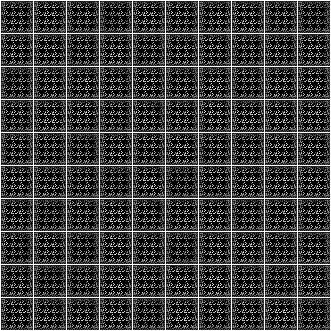

Starting 1
[2/8] - ptime: 42.31, loss_d: 2.40542197, loss_g: 2.38163090
[tensor(0.3600)]


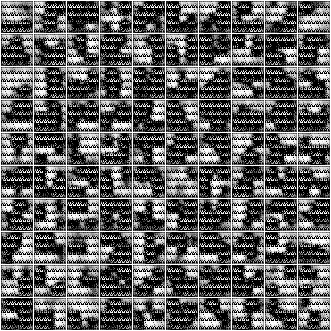

Starting 2
[3/8] - ptime: 42.27, loss_d: 0.26391584, loss_g: 0.25722891
[tensor(0.3600), tensor(0.0143)]


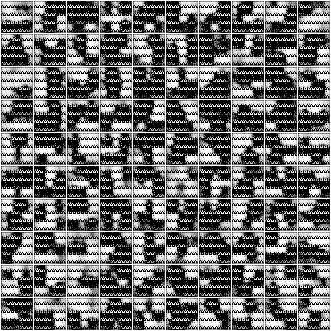

Starting 3
[4/8] - ptime: 42.94, loss_d: 0.07504353, loss_g: 0.07096542
[tensor(0.3600), tensor(0.0143), tensor(0.0060)]


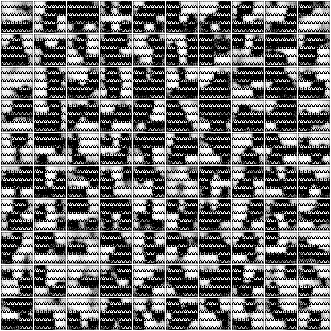

Starting 4
[5/8] - ptime: 53.23, loss_d: 0.03577449, loss_g: 0.03442864
[tensor(0.3600), tensor(0.0143), tensor(0.0060), tensor(0.0025)]


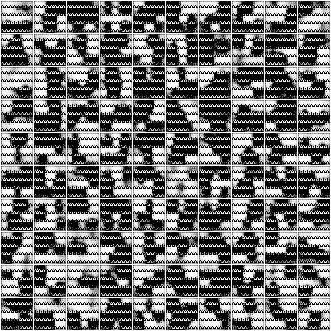

Starting 5


In [ ]:

print('training start!')
start_time = time.time()

for epoch in range(train_epoch):
    print('Starting', epoch)
    D_losses = []
    G_losses = []
    noise_losses = []

    # learning rate decay
    if (epoch+1) == 4:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

#     if (epoch+1) == 16:
#         G_optimizer.param_groups[0]['lr'] /= 10
#         D_optimizer.param_groups[0]['lr'] /= 10
#         print("learning rate change!")

    epoch_start_time = time.time()
    
    y_fake_ = torch.zeros(batch_size).type(torch.LongTensor)
    y_fake_ = Variable(y_fake_.cuda())

    for i in range(400):
        #################################################################################################
        # train discriminator D
        D.zero_grad()
     
        # train on generator output.
        z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1)
        y_ = (torch.rand(batch_size, 1) * n_numbers).type(torch.LongTensor).squeeze()
        y_ = y_ + 1
        y_label_ = onehot[y_]
        y_fill_ = fill[y_]
        z_, y_label_, y_fill_ = Variable(z_.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())
        
        # Generate images
        G_result = G(z_, y_label_)
        D_result = D(G_result).squeeze()
        assert G_result.shape[2] == img_size, (G_result.shape[2], img_size)

        D_gen_loss = NLL_loss(D_result, y_.cuda())
        D_fake_score = D_result.data.mean()

        # Train on noise.
        noise = normal.Normal(G_result.mean(), G_result.std()).sample(G_result.shape).cuda()
        D_result = D(noise).squeeze()
        D_fake_loss = NLL_loss(D_result, y_fake_)

        # Total loss
        D_train_loss = D_gen_loss + D_fake_loss
        D_train_loss.backward()
        
        D_optimizer.step()
        D_losses.append(D_train_loss.item())
        noise_losses.append(D_fake_loss.item())
        
        ################################################################################################
        # train generator G
        G.zero_grad()

        z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1)
        y_ = (torch.rand(batch_size, 1) * n_numbers).type(torch.LongTensor).squeeze()
        y_ = y_ + 1
        y_label_ = onehot[y_]
        y_fill_ = fill[y_]
        z_, y_label_, y_fill_ = Variable(z_.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())
    
        # Fake data loss.
        G_result = G(z_, y_label_)
        D_result = D(G_result).squeeze()

        G_train_loss = NLL_loss(D_result, y_.cuda())
        
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.8f, loss_g: %.8f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    print(train_hist['noise_losses'])
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), show=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['noise_losses'].append(torch.mean(torch.FloatTensor(noise_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))

print("Training finish!... save training results")
# torch.save(G.state_dict(), root + model + 'generator_param.pkl')
# torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

# show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

# images = []
# for e in range(train_epoch):
#     img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
#     images.append(imageio.imread(img_name))
# imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

In [ ]:
show_train_hist(train_hist, show=True, save=True, path=root + model + 'train_hist.png')

In [ ]:
images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)